## Getting Started

This is a guide how to get started solving an example problem using *pymoo*. The problem definition is outsourced to another library called [pymop](https://github.com/msu-coinlab/pymop). There, various test problems (single- as well as multi-objective) are defined. In addition to the objective values gradients are available as well. For details we refer to the corresping [documentation](https://www.egr.msu.edu/coinlab/blankjul/pymop/).

In this guide we are going to solve a bi-objective problem with the following definition:


$$\begin{align*} 
\text{Minimize} \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\text{Maxmize} \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\
\text{subject to} \;\; & g_1(x) = x_1^2 - x_1 \geq - \frac{3}{16} \\ 
& -2 < x_1 < 2 \\
& -2 < x_2 < 2
\end{align*}$$


### Define a Problem

In *pymoo* all functions are supposed to be **minimized**. However, in case of maximization (as you might alread now), you can simply multiply the objective by -1 and then minimize it. In our case, the second objective $f_2(x) = -(x_1-1)^2 - x_2^2$ to be maximized will become $f_2(x) = (x_1-1)^2 + x_2^2$ to be minimized.

Most of the algorithms in *pymoo* are able to handle constraints. A solution is defined to be feasible or infeasible as follows:


$$ \begin{cases}
\text{feasible,} \quad \quad \sum_i^n \langle g_i(x)\rangle = 0\\
\text{infeasbile,} \quad \quad \quad \text{otherwise}\\
\end{cases}
$$

$$
\text{where} \quad \langle g_i(x)\rangle =
\begin{cases}
0, \quad \quad \; \text{if} \; g_i(x) \leq 0\\
g_i(x), \quad  \text{otherwise}\\
\end{cases}
$$



Therefore, a constraint counts as violated when $g_i(x)$ is *positive* for at least one constraint. For the purpose of convergence it is useful to make sure the positive value corresponds to the amount of infeasibility. If $g_i(x)$ returns a negative value no constraint violation does exist and the solution is considered as feasible. 
In *pymoo* 
Therefore, the constraint function $g_i(x)$ needs to be converted to a $\leq 0$ constraint: $g_1(x) = -(x_1^2 - x_1 +\frac{3}{16}) \leq 0$.

Finally, the problem to be defined is:

$$\begin{align*} 
\text{Minimize} \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\text{Minimize} \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\
\text{subject to} \;\; & g_1(x) = - (x_1^2 - x_1 + \frac{3}{16}) \leq 0\\ 
& -2 < x_1 < 2 \\
& -2 < x_2 < 2
\end{align*}$$


The implementation of this problem is the follows: First, the problem class needs to be defined. One way to do that is by defining an object which inherits from the Problem class. The instructor needs to set the number of variables *n_var*, the number of objectives *n_obj*, the number of constraints *n_constr* and the variable boundaries (if applicable to the variable type). Moverover, the *\_evaluate* function needs to be overwritten. The input *x* is a 2d-array, where each row represents an entry to be evaluated.

In [1]:
import numpy as np
from pymop.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=1, 
                         xl=np.array([-2,-2]), xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]-1)**2 + x[:,1]**2
        out["F"] = np.column_stack([f1, f2])
        out["G"] = - (x[:,0]**2 - x[:,0] + 3/16)
        
problem = MyProblem()


### Initialize an Algorithm




Second, an algorithm to solve the problem need to be defined. Depending on the optimization problem different algorithms can be used to optimize the problem. Choosing an apropriate algorithm with suitable hyperparameters is a challange itself.
In our example, a bi-objective problem with one constraint can solved by using the well-known [NSGA-II](/algorithms/nsga2.html).

In [2]:
from pymoo.algorithms.nsga2 import nsga2

method = nsga2(pop_size=20)

### Optimize and Visualize

Third, we are solving the problem with the method we have just defined. The [Result](/api/model.html#pymoo.model.result.Result) object provides the corresponding *X* and *F* values and much more information. For instance, because we have enabled the *save_history* flag, we can analyze the optimization run over time and track the performance.


Design Space


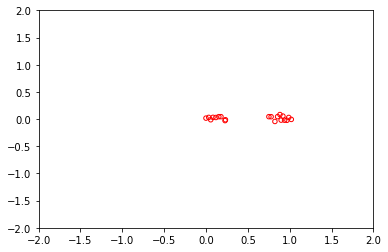


Objective Space


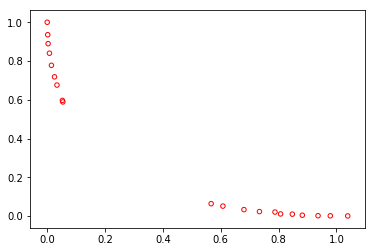

In [3]:
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.util import plotting

res = minimize(problem,
               method,
               termination=('n_gen', 20),
               seed=1,
               save_history=True,
               disp=False)

print("\nDesign Space")
plotting.plot(res.X, show=False, no_fill=True)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.show()

print("\nObjective Space")
plotting.plot(res.F, no_fill=True)


### Performance Tracking

Because we also saved the history, we can now analyze the convergence over time. To measure the performance we need to decide what metric to be used. Here, we have using Hypervolume.

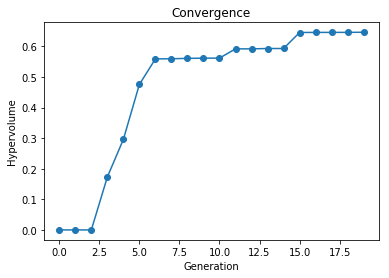

In [4]:
from pymoo.indicators.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1.0, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# visualze the convergence curve 
plt.plot(np.arange(len(hv)), hv, '-o')
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.show()
